In [1]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
#dfine the model to delete the anomaly data
def transform(data):
    whole_tag = []
    name = data.columns[1]
    for i in data.groupby(name)['Tag0']:
        a = list(i[1])
        if len(a)<4:
            while True:
                a.append('nan')
                if len(a) == 4:
                    break
        time = i[0]
        a.append(time)
        whole_tag.append(a)
    data_fag = pd.DataFrame(whole_tag)
#     print(data_fag.head())
    if len(data_fag.columns) !=5:
        data_fag.drop(list(data_fag.columns[5:]), axis=1 , inplace = True)
    data_fag.columns = ['postion1' ,'postion2','postion3','postion4','time_tag' ]
    data_fag = data_fag.astype('float')
#     data_fag.columns = []
    return data_fag
def getDistanceByPoint(data, model):
    distance = pd.Series(dtype='float64')
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] =  np.linalg.norm(Xa-Xb)
    return distance

In [90]:
def anomaly_detection(df):
#     l1 = len(df)
    df = transform(df)
#     l2 = len(df)
    df = df.dropna(axis=0)
#     l3 = len(df)
    # print(len(df))
    # delete duplicate data
    df = df.drop_duplicates(subset = ['postion1' ,'postion2','postion3' ,'postion4'] , keep = 'first')
#     l4 = len(df)
    df.reset_index(inplace = True)
    data = df[['postion1' ,'postion2','postion3' ,'postion4']]
#     print(len(df))
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(data)
    data = pd.DataFrame(np_scaled)
#     print(len(data))
    # reduce to 2 importants features
    pca = PCA(n_components=2)
    data = pca.fit_transform(data)
    # standardize these 2 new features
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(data)
    data = pd.DataFrame(np_scaled)
    n_cluster = range(1, 20)
    # use 14 as the parameter
    kmeans = KMeans(n_clusters=14).fit(data) 
#     scores = [kmeans[i].score(data) for i in range(len(kmeans))]
    df['cluster'] = kmeans.predict(data)
    df['principal_feature1'] = data[0]
    df['principal_feature2'] = data[1]
#     df['cluster'].value_counts()
    outliers_fraction = 0.16

    distance = getDistanceByPoint(data, kmeans)
    number_of_outliers = int(outliers_fraction*len(distance))
    threshold = distance.nlargest(number_of_outliers).min()
    # anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
    df['anomaly21'] = (distance >= threshold).astype(int)
#     l5 = len(df)
    return df

    

In [3]:
path_anomaly = 'C:\\Users\\luzheng\\Desktop\\E\\异常数据\\'
path_true = 'C:\\Users\\luzheng\\Desktop\\E\\正常数据\\'
# data_fake_24 = pd.read_csv(path_anomaly+'24.异常.txt' , sep = ':')
# data_real_109 = pd.read_csv(path_true+'109.正常.txt' , sep = ':')
# data_real_24 = pd.read_csv(path_true+'24.正常.txt' , sep = ':')
# data_fake_1 = pd.read_csv(path_anomaly+'1.异常.txt' , sep = ':')
# data_fake_100 = pd.read_csv(path_anomaly+'100.异常.txt' , sep = ':')

# data_real_24 = anomaly_detection(data_real_24)
# data_real_109 = anomaly_detection(data_real_109)
# data_fake_1 = anomaly_detection(data_fake_1)
# data_fake_100 = anomaly_detection(data_fake_100)

In [14]:
def get_csv(data ,path):
    df = data[['postion1' ,'postion2','postion3' ,'postion4']]
    df.to_csv(path)
get_csv(data_real_24 ,'data_real_24.csv')
get_csv(data_real_109 ,'data_real_109.csv' )
get_csv(data_fake_1,'data_fake_1.csv')
get_csv(data_fake_100 ,'data_fake_100.csv' )


In [10]:
import os
tag_position = pd.read_csv('Tag坐标信息.txt' ,sep = ' ' )
list_real = os.listdir('C:\\Users\\luzheng\\Desktop\\E\\异常数据\\')
print(list_real[:10])


['1.异常.txt', '10.异常.txt', '100.异常.txt', '101.异常.txt', '102.异常.txt', '103.异常.txt', '104.异常.txt', '105.异常.txt', '106.异常.txt', '107.异常.txt']


In [5]:
# tag_position.drop(tag_position.columns[4:],axis=1, inplace = True)
# tag_position.columns = ['code', 'X' ,'Y' , 'Z']
# tag_position['new_code'] = range(1,len(tag_position)+1)
#发现有缺失数据。手动补出来
# tag_position.to_csv('./模型数据/tag_position.csv')
tag_position = pd.read_csv('./模型数据/tag_position.csv')
tag_position.isnull().sum()

Unnamed: 0    0
code          0
X             0
Y             0
Z             0
dtype: int64

In [11]:
# tag_position.drop(['Unnamed: 4','Z'] ,axis=1,inplace = True)
# tag_position.columns = ['编号' , 'X' , 'Y','Z']
# tag_position.head()
'''
'''
#retreive 20%data from the dataset
# 的去模型数据时，用50%的缺失数据，70%的正确数据
frac_data = 1
step = 0
data_merge = []
error_list = []
for i in list_real:
    df = pd.read_csv(path_anomaly+i , sep = ':')
#     print(df.head())
    try:
        df = transform(df)
        name = i.split('.')[0]
        df = df[['postion1' ,'postion2','postion3' ,'postion4']]
        df['code'] = name
        # sample 20% data from the cleaning datasets
        df = df.sample(frac = 1)[:int(len(df)*frac_data)]
        for i in df.values:
            data_merge.append(list(i))
    except : 
        error_list.append(i)
        print(i,' has error')
    

In [12]:
all_data = pd.DataFrame(data_merge)

In [13]:
all_data.columns = ['position1', 'position2','position3','position4','code']
all_data.to_csv('无处理有干扰总数据.csv')
all_data

,position1,position2,position3,position4,code
0,1200.0,4550.0,4550.0,6300.0,1
1,760.0,5070.0,4540.0,6300.0,1
2,770.0,5030.0,4540.0,6290.0,1
3,760.0,5010.0,4550.0,6300.0,1
4,1250.0,4550.0,4560.0,6300.0,1
...,...,...,...,...,...
95662,1430.0,4090.0,4520.0,6010.0,99
95663,920.0,4090.0,4510.0,6510.0,99
95664,1460.0,4090.0,4520.0,6010.0,99
95665,1440.0,4120.0,4530.0,5980.0,99


In [77]:
all_data = pd.read_csv('处理后干扰下数据.csv')
all_data

,Unnamed: 0,position1,position2,position3,position4,code,X,Y,Z
0,0,770.0,4540.0,4540.0,6310.0,1,50,50,88.0
1,1,770.0,4540.0,4570.0,6290.0,1,50,50,88.0
2,2,760.0,4550.0,4560.0,6300.0,1,50,50,88.0
3,3,760.0,4550.0,4560.0,6290.0,1,50,50,88.0
4,4,750.0,4550.0,4550.0,6310.0,1,50,50,88.0
...,...,...,...,...,...,...,...,...,...
6424,6424,930.0,4110.0,4520.0,5990.0,99,100,50,130.0
6425,6425,930.0,4100.0,4530.0,5980.0,99,100,50,130.0
6426,6426,920.0,4090.0,4530.0,6020.0,99,100,50,130.0
6427,6427,940.0,4090.0,4510.0,6000.0,99,100,50,130.0


In [78]:
real_data = []
for i in all_data.values:
    real_data.append(list(i))
real_data

[[0.0, 770.0, 4540.0, 4540.0, 6310.0, 1.0, 50.0, 50.0, 88.0],
 [1.0, 770.0, 4540.0, 4570.0, 6290.0, 1.0, 50.0, 50.0, 88.0],
 [2.0, 760.0, 4550.0, 4560.0, 6300.0, 1.0, 50.0, 50.0, 88.0],
 [3.0, 760.0, 4550.0, 4560.0, 6290.0, 1.0, 50.0, 50.0, 88.0],
 [4.0, 750.0, 4550.0, 4550.0, 6310.0, 1.0, 50.0, 50.0, 88.0],
 [5.0, 750.0, 4550.0, 4540.0, 6290.0, 1.0, 50.0, 50.0, 88.0],
 [6.0, 750.0, 4540.0, 4560.0, 6300.0, 1.0, 50.0, 50.0, 88.0],
 [7.0, 780.0, 4550.0, 4560.0, 6300.0, 1.0, 50.0, 50.0, 88.0],
 [8.0, 780.0, 4550.0, 4560.0, 6310.0, 1.0, 50.0, 50.0, 88.0],
 [9.0, 760.0, 4560.0, 4550.0, 6310.0, 1.0, 50.0, 50.0, 88.0],
 [10.0, 740.0, 4550.0, 4570.0, 6300.0, 1.0, 50.0, 50.0, 88.0],
 [11.0, 750.0, 4550.0, 4570.0, 6300.0, 1.0, 50.0, 50.0, 88.0],
 [12.0, 770.0, 4540.0, 4540.0, 6290.0, 1.0, 50.0, 50.0, 88.0],
 [13.0, 780.0, 4550.0, 4540.0, 6290.0, 1.0, 50.0, 50.0, 88.0],
 [14.0, 780.0, 4540.0, 4550.0, 6310.0, 1.0, 50.0, 50.0, 88.0],
 [15.0, 780.0, 4560.0, 4560.0, 6310.0, 1.0, 50.0, 50.0, 88.0],
 [

In [29]:
tag_position.drop(tag_position.columns[4:],axis=1, inplace = True)
tag_position.columns = ['code', 'X' ,'Y' , 'Z']
tag_position['new_code'] = range(1,len(tag_position)+1)

In [35]:
len(tag_position)

320

In [36]:
# dict_data = {code:[]}
for data in real_data:
    data.extend(list(tag_position.iloc[int(data[-1])-1,1:4]) )
     

In [38]:
real_data

[[0.0, 770.0, 4540.0, 4540.0, 6310.0, 1.0, 50.0, 50.0, 88.0, 50, 450, 130.0],
 [1.0, 770.0, 4540.0, 4570.0, 6290.0, 1.0, 50.0, 50.0, 88.0, 50, 450, 130.0],
 [2.0, 760.0, 4550.0, 4560.0, 6300.0, 1.0, 50.0, 50.0, 88.0, 50, 450, 130.0],
 [3.0, 760.0, 4550.0, 4560.0, 6290.0, 1.0, 50.0, 50.0, 88.0, 50, 450, 130.0],
 [4.0, 750.0, 4550.0, 4550.0, 6310.0, 1.0, 50.0, 50.0, 88.0, 50, 450, 130.0],
 [5.0, 750.0, 4550.0, 4540.0, 6290.0, 1.0, 50.0, 50.0, 88.0, 50, 450, 130.0],
 [6.0, 750.0, 4540.0, 4560.0, 6300.0, 1.0, 50.0, 50.0, 88.0, 50, 450, 130.0],
 [7.0, 780.0, 4550.0, 4560.0, 6300.0, 1.0, 50.0, 50.0, 88.0, 50, 450, 130.0],
 [8.0, 780.0, 4550.0, 4560.0, 6310.0, 1.0, 50.0, 50.0, 88.0, 50, 450, 130.0],
 [9.0, 760.0, 4560.0, 4550.0, 6310.0, 1.0, 50.0, 50.0, 88.0, 50, 450, 130.0],
 [10.0, 740.0, 4550.0, 4570.0, 6300.0, 1.0, 50.0, 50.0, 88.0, 50, 450, 130.0],
 [11.0, 750.0, 4550.0, 4570.0, 6300.0, 1.0, 50.0, 50.0, 88.0, 50, 450, 130.0],
 [12.0, 770.0, 4540.0, 4540.0, 6290.0, 1.0, 50.0, 50.0, 88.0, 

In [37]:
cl = ['position1','position2','position3','position4','code','X', 'Y' , 'Z']
position_plus_data = pd.DataFrame(real_data , columns = cl)

ValueError: 8 columns passed, passed data had 12 columns

In [14]:
position_plus_data.to_csv('postion_merge_fake.csv')

In [15]:
real = []
for i in position_plus_data.values:
    a = list(i)
    real.append(a)


In [70]:

# def solve_function(unsolved_value , test):
#     x,y,z=unsolved_value[0],unsolved_value[1],unsolved_value[2]
    
#     return [
#         x**2+y**2+(z-1300)**2-test[0]**2,
#         (x-5000)**2+y**2+(z-1700)**2-test[1]**2,
#          (x)**2+(y-5000)**2+(z-1700)**2-test[2]**2,
#         (x-5000)**2+(y-5000)**2+(z-1300)**2-test[3]**2,
        
#     ]

In [53]:

from scipy.optimize import fsolve
from math import sin,cos
# result = 
# solved=fsolve(solve_function,[0, 0, 0, 0])


In [79]:
for i in real_data:
    print(i[1:5])
    break

[770.0, 4540.0, 4540.0, 6310.0]


In [80]:
test_all = []
for i in real_data: #real_data
#     print(i[:4])
    test = i[1:5]
    def solve_function(unsolved_value ):
        x,y,z=unsolved_value[0],unsolved_value[1],unsolved_value[2]
        d1 = np.sqrt(x**2+y**2+(z-1300)**2)
        d2 = np.sqrt((x-5000)**2+y**2+(z-1700)**2)
        d3 = np.sqrt((x)**2+(y-5000)**2+(z-1700)**2)
        d4 = np.sqrt((x-5000)**2+(y-5000)**2+(z-1300)**2)
        return [
#             x**2+y**2+(z-1300)**2-test[0]**2, # d1
#             (x-5000)**2+y**2+(z-1700)**2-test[1]**2, # d2
#              (x)**2+(y-5000)**2+(z-1700)**2-test[2]**2, # d3
#             (x-5000)**2+(y-5000)**2+(z-1300)**2-test[3]**2, #d4
#             #双曲率
            test[0]-test[1] - (d1-d2),
            test[1]-test[2] - (d2-d3),
            test[2]-test[3] - (d3-d4),
            test[3]-test[0] - (d4-d1),
            

        ]
    solved=fsolve(solve_function,[0, 0, 0, 0])
    test_all.append(list(solved)[:3])


C:\anaconda\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\anaconda\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [81]:

step = 0
for i in real_data:
    i.extend(test_all[step])
    step+=1


In [82]:
model_1_data = pd.DataFrame(real_data)


In [83]:
model_1_data.columns = ['num','position1','position2','position3','position4','code','X', 'Y' , 'Z' , 'pre_X' , 'pre_Y' ,'pre_Z' ,]
# model_1_data.sample(frac=1).apply(lambda x : x[['pre_X','pre_Y','pre_Z']]=x[['pre_X','pre_Y','pre_Z']]/10 )

In [84]:
model_1_data[['pre_X','pre_Y','pre_Z']] = model_1_data[['pre_X','pre_Y','pre_Z']].apply(lambda x: x/10)

In [85]:
model_1_data.sample(frac=1)

,num,position1,position2,position3,position4,code,X,Y,Z,pre_X,pre_Y,pre_Z
3345,3345.0,4640.0,6080.0,1060.0,3980.0,253.0,100.0,450.0,200.0,95.647435,462.329800,1.202097e+02
4589,4589.0,4620.0,2180.0,4970.0,3130.0,312.0,400.0,200.0,200.0,418.590021,204.620461,2.749685e+02
2209,2209.0,2760.0,3560.0,3580.0,4250.0,195.0,200.0,200.0,170.0,-420554.890389,-433110.421470,-2.790163e+06
1047,1047.0,5290.0,4200.0,3640.0,1660.0,143.0,350.0,400.0,130.0,672.722423,832.833509,-1.013658e+03
3550,3550.0,2560.0,4090.0,3280.0,4700.0,265.0,150.0,200.0,200.0,140.668217,201.354396,2.214792e+02
...,...,...,...,...,...,...,...,...,...,...,...,...
5342,5342.0,3070.0,2360.0,5030.0,4440.0,53.0,300.0,100.0,88.0,299.554111,92.624547,4.445128e+01
2585,2585.0,3060.0,2250.0,4990.0,4480.0,215.0,300.0,100.0,170.0,296.370059,95.021330,1.189968e+02
4970,4970.0,2450.0,2600.0,5290.0,5120.0,37.0,250.0,50.0,88.0,255.174595,12.376486,-3.066904e+01
5489,5489.0,2960.0,5420.0,2140.0,4830.0,6.0,50.0,300.0,88.0,40.779245,304.542521,4.032872e+01


In [71]:
model_1_data.to_csv('正常处理后数据普通求解.csv')

In [107]:
final_result = pd.read_csv('正常处理后数据普通求解.csv')


,Unnamed: 0,num,position1,position2,position3,position4,code,X,Y,Z,pre_X,pre_Y,pre_Z
0,0,0.0,770.0,4540.0,4540.0,6310.0,1.0,50.0,50.0,88.0,54.056105,54.056105,105.253233
1,1,1.0,770.0,4540.0,4570.0,6290.0,1.0,50.0,50.0,88.0,57.022113,54.295596,90.662446
2,2,2.0,760.0,4550.0,4560.0,6300.0,1.0,50.0,50.0,88.0,55.351762,54.442899,93.697272
3,3,3.0,760.0,4550.0,4560.0,6290.0,1.0,50.0,50.0,88.0,56.065282,55.157120,91.093502
4,4,4.0,750.0,4550.0,4550.0,6310.0,1.0,50.0,50.0,88.0,54.082430,54.082430,99.850155
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6424,6424,6424.0,930.0,4110.0,4520.0,5990.0,99.0,100.0,50.0,130.0,94.131418,59.089972,135.434699
6425,6425,6425.0,930.0,4100.0,4530.0,5980.0,99.0,100.0,50.0,130.0,95.568918,58.815519,132.445769
6426,6426,6426.0,920.0,4090.0,4530.0,6020.0,99.0,100.0,50.0,130.0,93.828396,56.340717,146.432841
6427,6427,6427.0,940.0,4090.0,4510.0,6000.0,99.0,100.0,50.0,130.0,94.282429,58.576171,146.325881


C:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

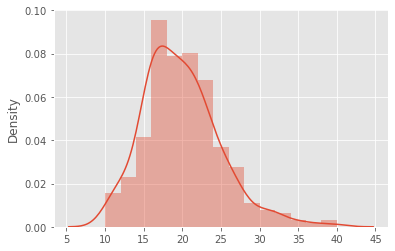

In [104]:
data_num = []
for i in all_data.groupby('code')['Z']:
#     print(len(i[1]))
    data_num.append(len(i[1]))
sns.distplot(data_num)

C:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

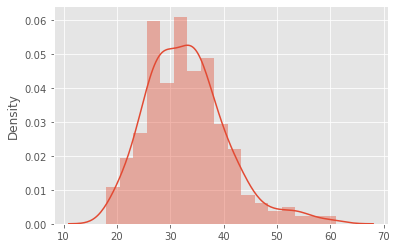

In [106]:
data_2 = pd.read_csv('普通解方程利用异常数据.csv')
data_num = []
for i in data_2.groupby('code')['Z']:
#     print(len(i[1]))
    data_num.append(len(i[1]))
sns.distplot(data_num)

In [117]:
a = final_result.groupby('code')[['X','Y','Z','pre_X' ,'pre_Y','pre_Z']].median()
a

,X,Y,Z,pre_X,pre_Y,pre_Z
code,,,,,,
1.0,50.0,50.0,88.0,55.250355,54.299814,95.525226
2.0,50.0,100.0,88.0,55.783455,105.233018,80.110045
3.0,50.0,150.0,88.0,56.949907,153.592258,95.550677
4.0,50.0,200.0,88.0,54.299404,205.292794,102.826994
5.0,50.0,250.0,88.0,59.457794,251.502263,119.001439
...,...,...,...,...,...,...
320.0,450.0,250.0,200.0,457.811339,258.840228,196.734433
321.0,450.0,300.0,200.0,452.897941,309.179146,185.668106
322.0,450.0,350.0,200.0,452.170976,356.193519,187.363746


In [119]:
b = final_result.groupby('code')[['X','Y','Z','pre_X' ,'pre_Y','pre_Z']].mean()
b

,X,Y,Z,pre_X,pre_Y,pre_Z
code,,,,,,
1.0,50.0,50.0,88.0,55.146043,54.520998,95.684297
2.0,50.0,100.0,88.0,55.439125,105.163058,80.408402
3.0,50.0,150.0,88.0,56.933458,153.385830,94.741425
4.0,50.0,200.0,88.0,54.405243,204.996064,103.580123
5.0,50.0,250.0,88.0,59.289721,251.586033,118.554629
...,...,...,...,...,...,...
320.0,450.0,250.0,200.0,457.741321,258.816784,197.409941
321.0,450.0,300.0,200.0,452.690829,308.909928,185.841703
322.0,450.0,350.0,200.0,452.270607,355.978422,187.135376


In [120]:
data_fake = ('普通解方程利用异常数据.csv')
a_fake = final_result.groupby('code')[['X','Y','Z','pre_X' ,'pre_Y','pre_Z']].median()
b_fake = final_result.groupby('code')[['X','Y','Z','pre_X' ,'pre_Y','pre_Z']].mean()
a_fake

,X,Y,Z,pre_X,pre_Y,pre_Z
code,,,,,,
1.0,50.0,50.0,88.0,55.250355,54.299814,95.525226
2.0,50.0,100.0,88.0,55.783455,105.233018,80.110045
3.0,50.0,150.0,88.0,56.949907,153.592258,95.550677
4.0,50.0,200.0,88.0,54.299404,205.292794,102.826994
5.0,50.0,250.0,88.0,59.457794,251.502263,119.001439
...,...,...,...,...,...,...
320.0,450.0,250.0,200.0,457.811339,258.840228,196.734433
321.0,450.0,300.0,200.0,452.897941,309.179146,185.668106
322.0,450.0,350.0,200.0,452.170976,356.193519,187.363746


In [121]:
b_fake

,X,Y,Z,pre_X,pre_Y,pre_Z
code,,,,,,
1.0,50.0,50.0,88.0,55.146043,54.520998,95.684297
2.0,50.0,100.0,88.0,55.439125,105.163058,80.408402
3.0,50.0,150.0,88.0,56.933458,153.385830,94.741425
4.0,50.0,200.0,88.0,54.405243,204.996064,103.580123
5.0,50.0,250.0,88.0,59.289721,251.586033,118.554629
...,...,...,...,...,...,...
320.0,450.0,250.0,200.0,457.741321,258.816784,197.409941
321.0,450.0,300.0,200.0,452.690829,308.909928,185.841703
322.0,450.0,350.0,200.0,452.270607,355.978422,187.135376


In [123]:
a.to_csv('中间值_真实数据最终结果.csv')
b.to_csv('平均值_真实数据最终结果.csv')
a_fake.to_csv('中间值_假的数据最终结果.csv')
b_fake.to_csv('平均值_假的数据最终结果.csv')
